In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [177]:
data = pd.read_csv("../data/raw/bank-marketing-campaign-data.csv", sep = ";")

col_categoricas = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
col_numericas = ["age", "duration", "campaign", "pdays", "previous",'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
target = ["y"]


In [178]:
data.shape

(41188, 21)

In [ ]:
data = data.drop_duplicates().reset_index(drop = True)

In [179]:
data['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [180]:
data['education'] = data['education'].replace(
    {'basic.4y': 'basic', 'basic.6y': 'basic', 'basic.9y': 'basic'}
)

data['education'] = data['education'].where(~data['education'].isin(['illiterate', 'unknown']), 'unknown')

data['job'] = data['job'].where(~data['job'].isin(['unknown', 'unemployed']), 'unknown')

data['default'] = data['default'].where(~data['default'].isin(['unknown']), 'yes')

data['poutcome'] = data['poutcome'].where(~data['poutcome'].isin(['failure',  'nonexistent']), 'failure')

In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

- Existen un total de 48188 filas (en este caso, clientes) y 21 columnas, de entre las que encontramos el objetivo o clase a predecir, `y`.
- No hay columnas con valores nulos. 
- Los datos cuentan con 10 características numéricas y 11 características categóricas.

In [182]:
# data.drop(['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1, inplace=True)

DUPLICADOS Y VALORES INSIGNIFICANTES 

- Como no existe una variable identificativa para cada cliente, no podemos deducir que haya clientes duplicados. Entonces no se eliminan. O SI? 
- Al no tener muy claro que variables son relevantes he decidido no elminar ninguna y más adelante tomar las decisiones pertinentes. 

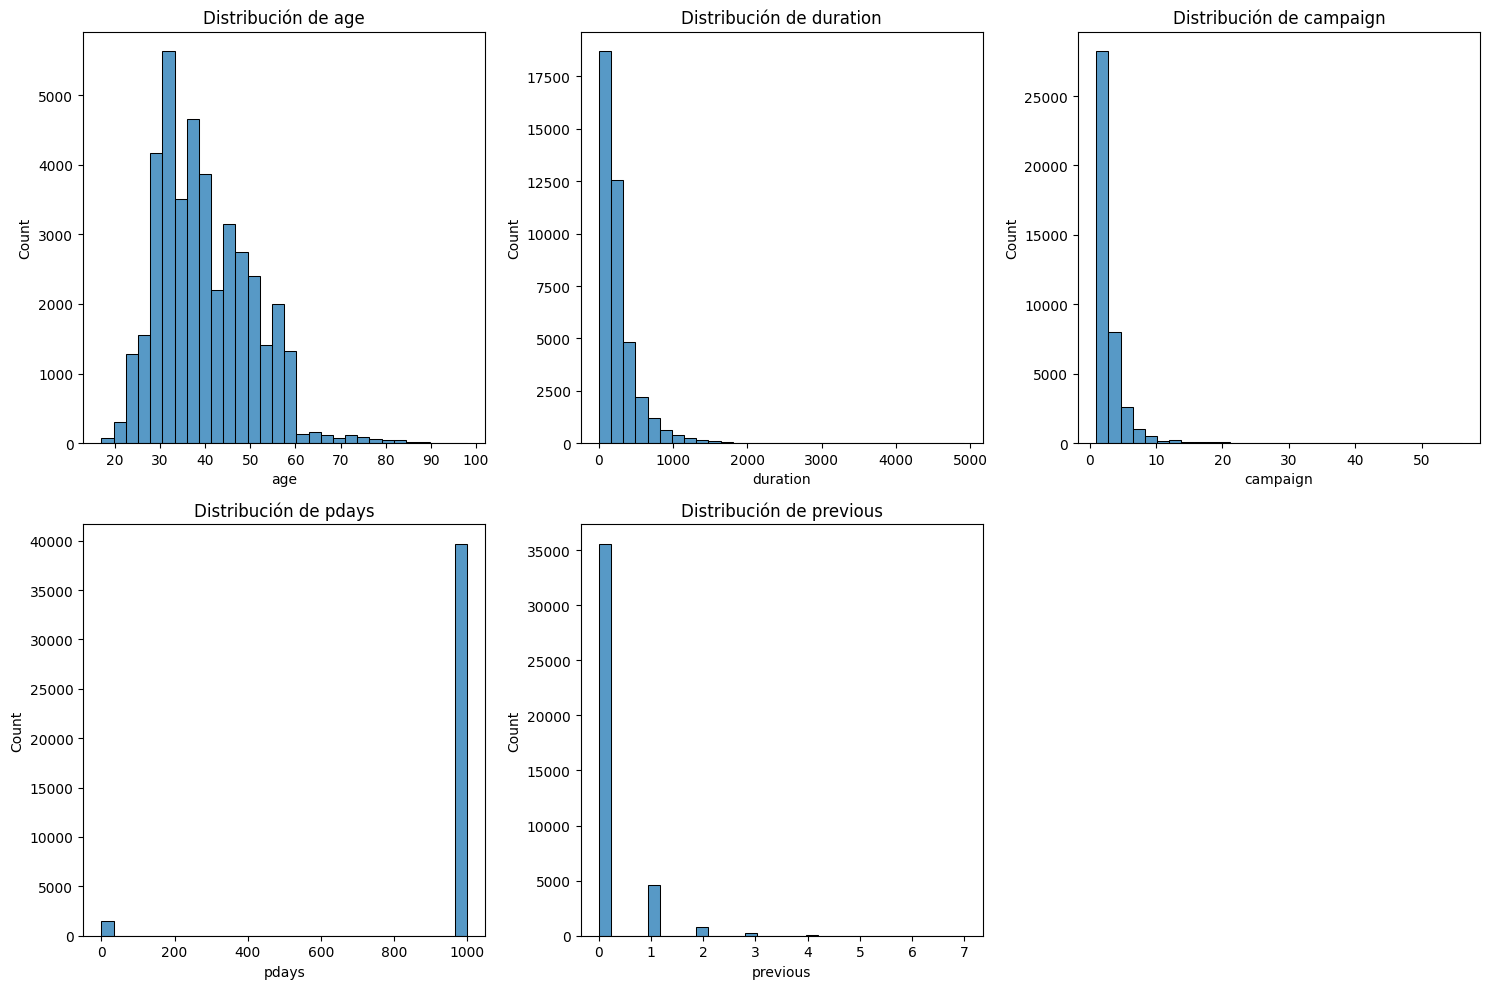

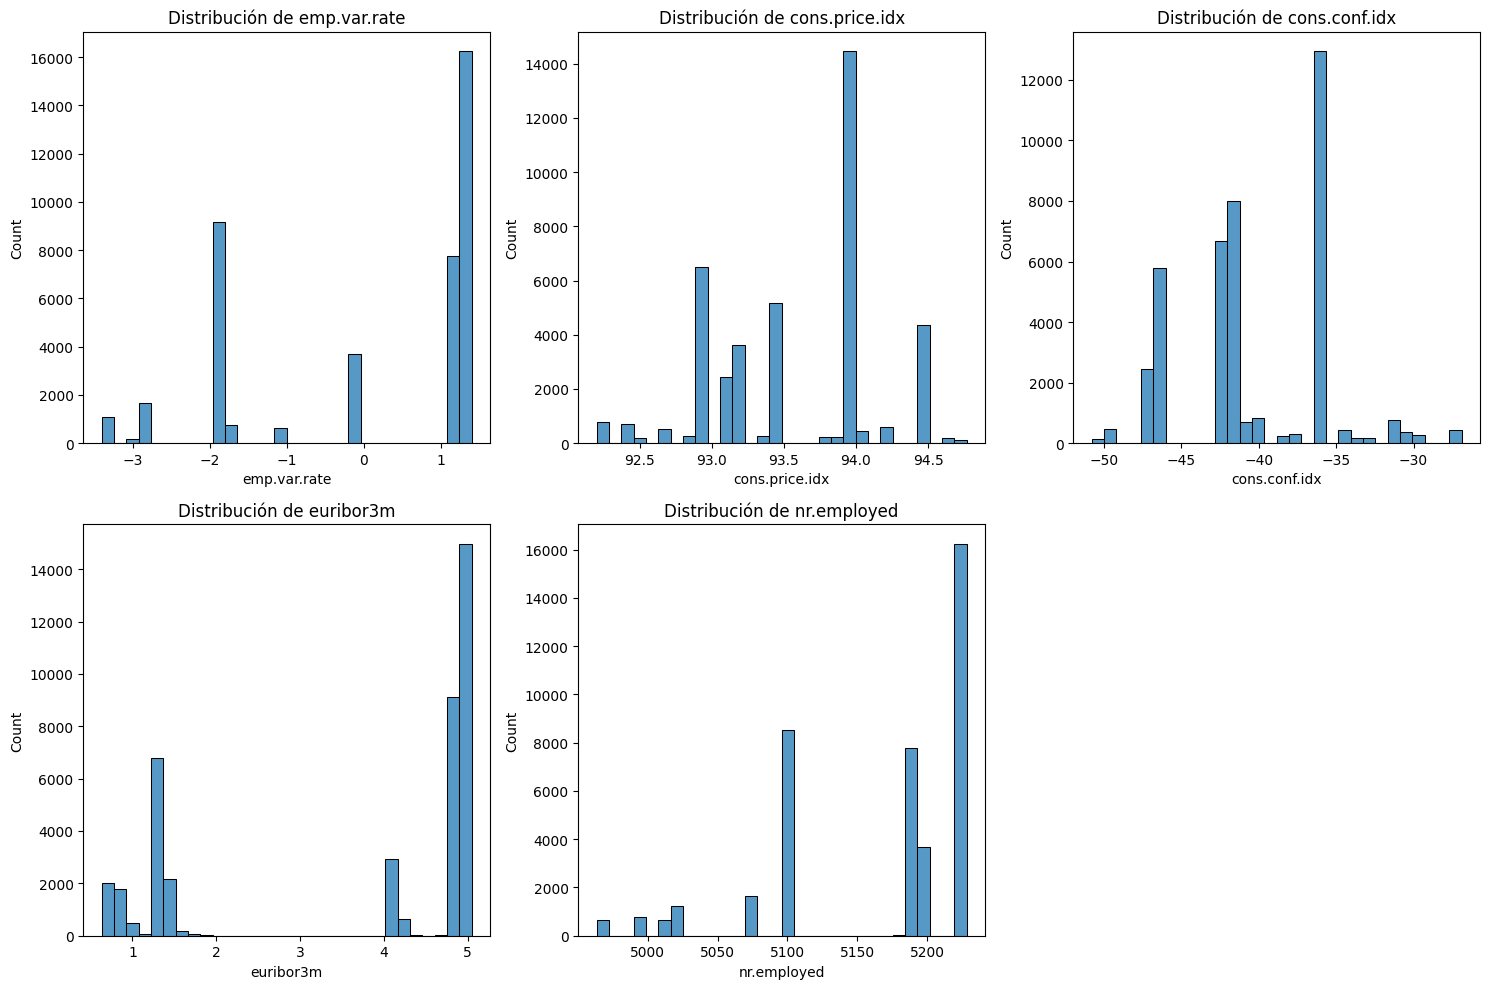

In [183]:
def graficar_distribucion_numerica(df, columnas):
    
    # Definir el número de columnas en la cuadrícula
    n = len(columnas)
    n_columnas = 3  # Máximo de 3 columnas por fila
    n_filas = (n // n_columnas) + (n % n_columnas > 0)  # Calcular el número de filas
    
    # Crear un grid de subgráficos
    fig, axes = plt.subplots(n_filas, n_columnas, figsize=(n_columnas * 5, n_filas * 5))
    
    # Aplanar el array de axes para poder iterar fácilmente
    axes = axes.flatten()
    
    # Graficar cada columna
    for i, col in enumerate(columnas):
        sns.histplot(df[col], bins=30, ax=axes[i])
        axes[i].set_title(f'Distribución de {col}')
    
    # Si hay menos gráficos que subgráficos, ocultamos los ejes restantes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')  # Ocultar los ejes que no tienen gráficos
    
    # Ajustar el layout para que no se sobrepongan los gráficos
    plt.tight_layout()
    plt.show()

graficar_distribucion_numerica(data, col_numericas[0:5])
graficar_distribucion_numerica(data, col_numericas[5:10])

Con la representación de cada variable podemos determinar que:

-
-
-
-
-
-
-
-
-
-

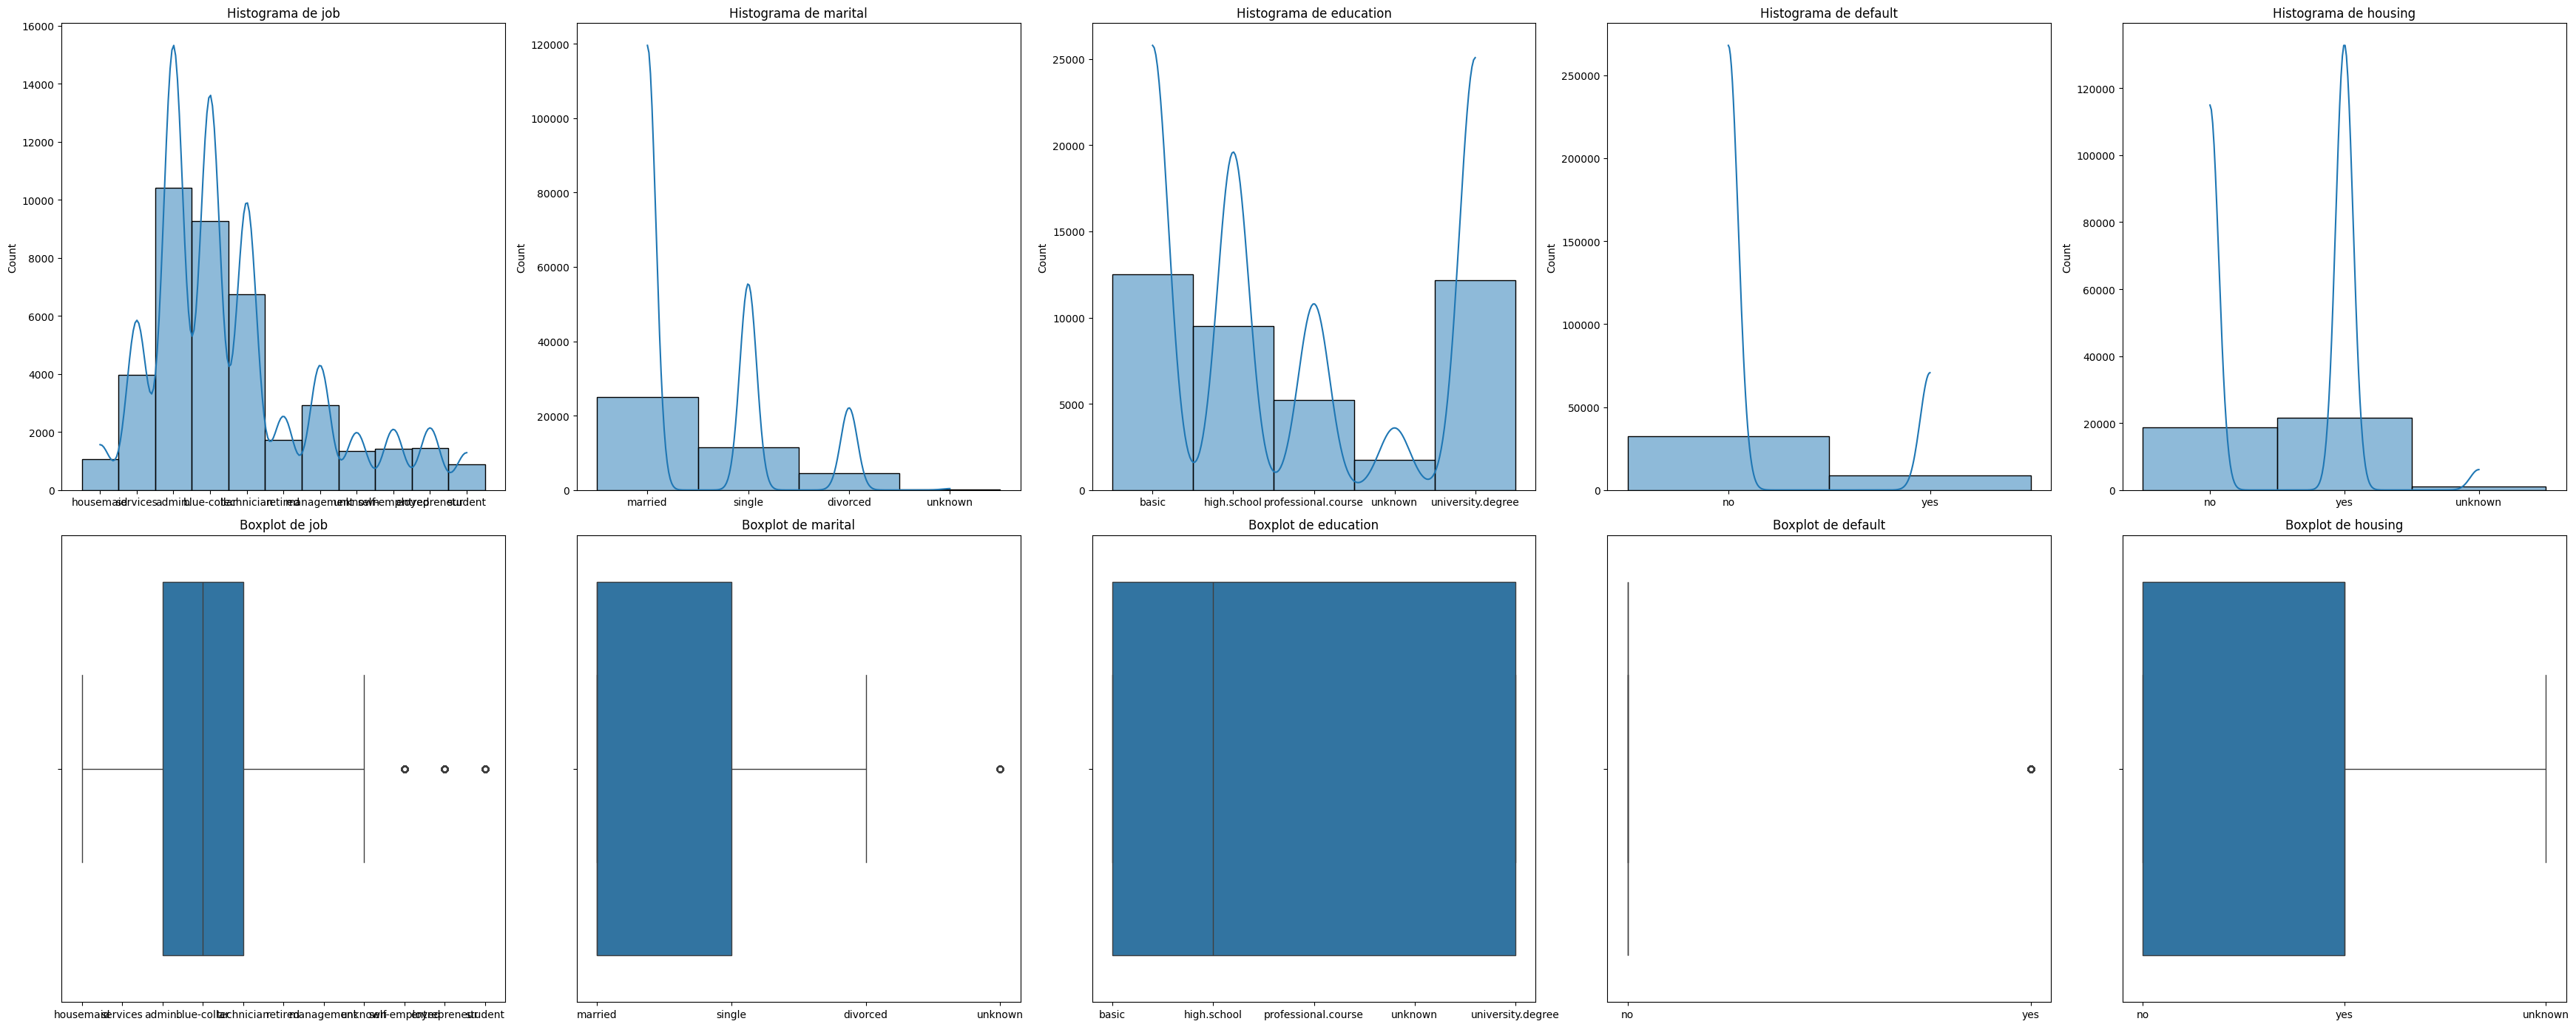

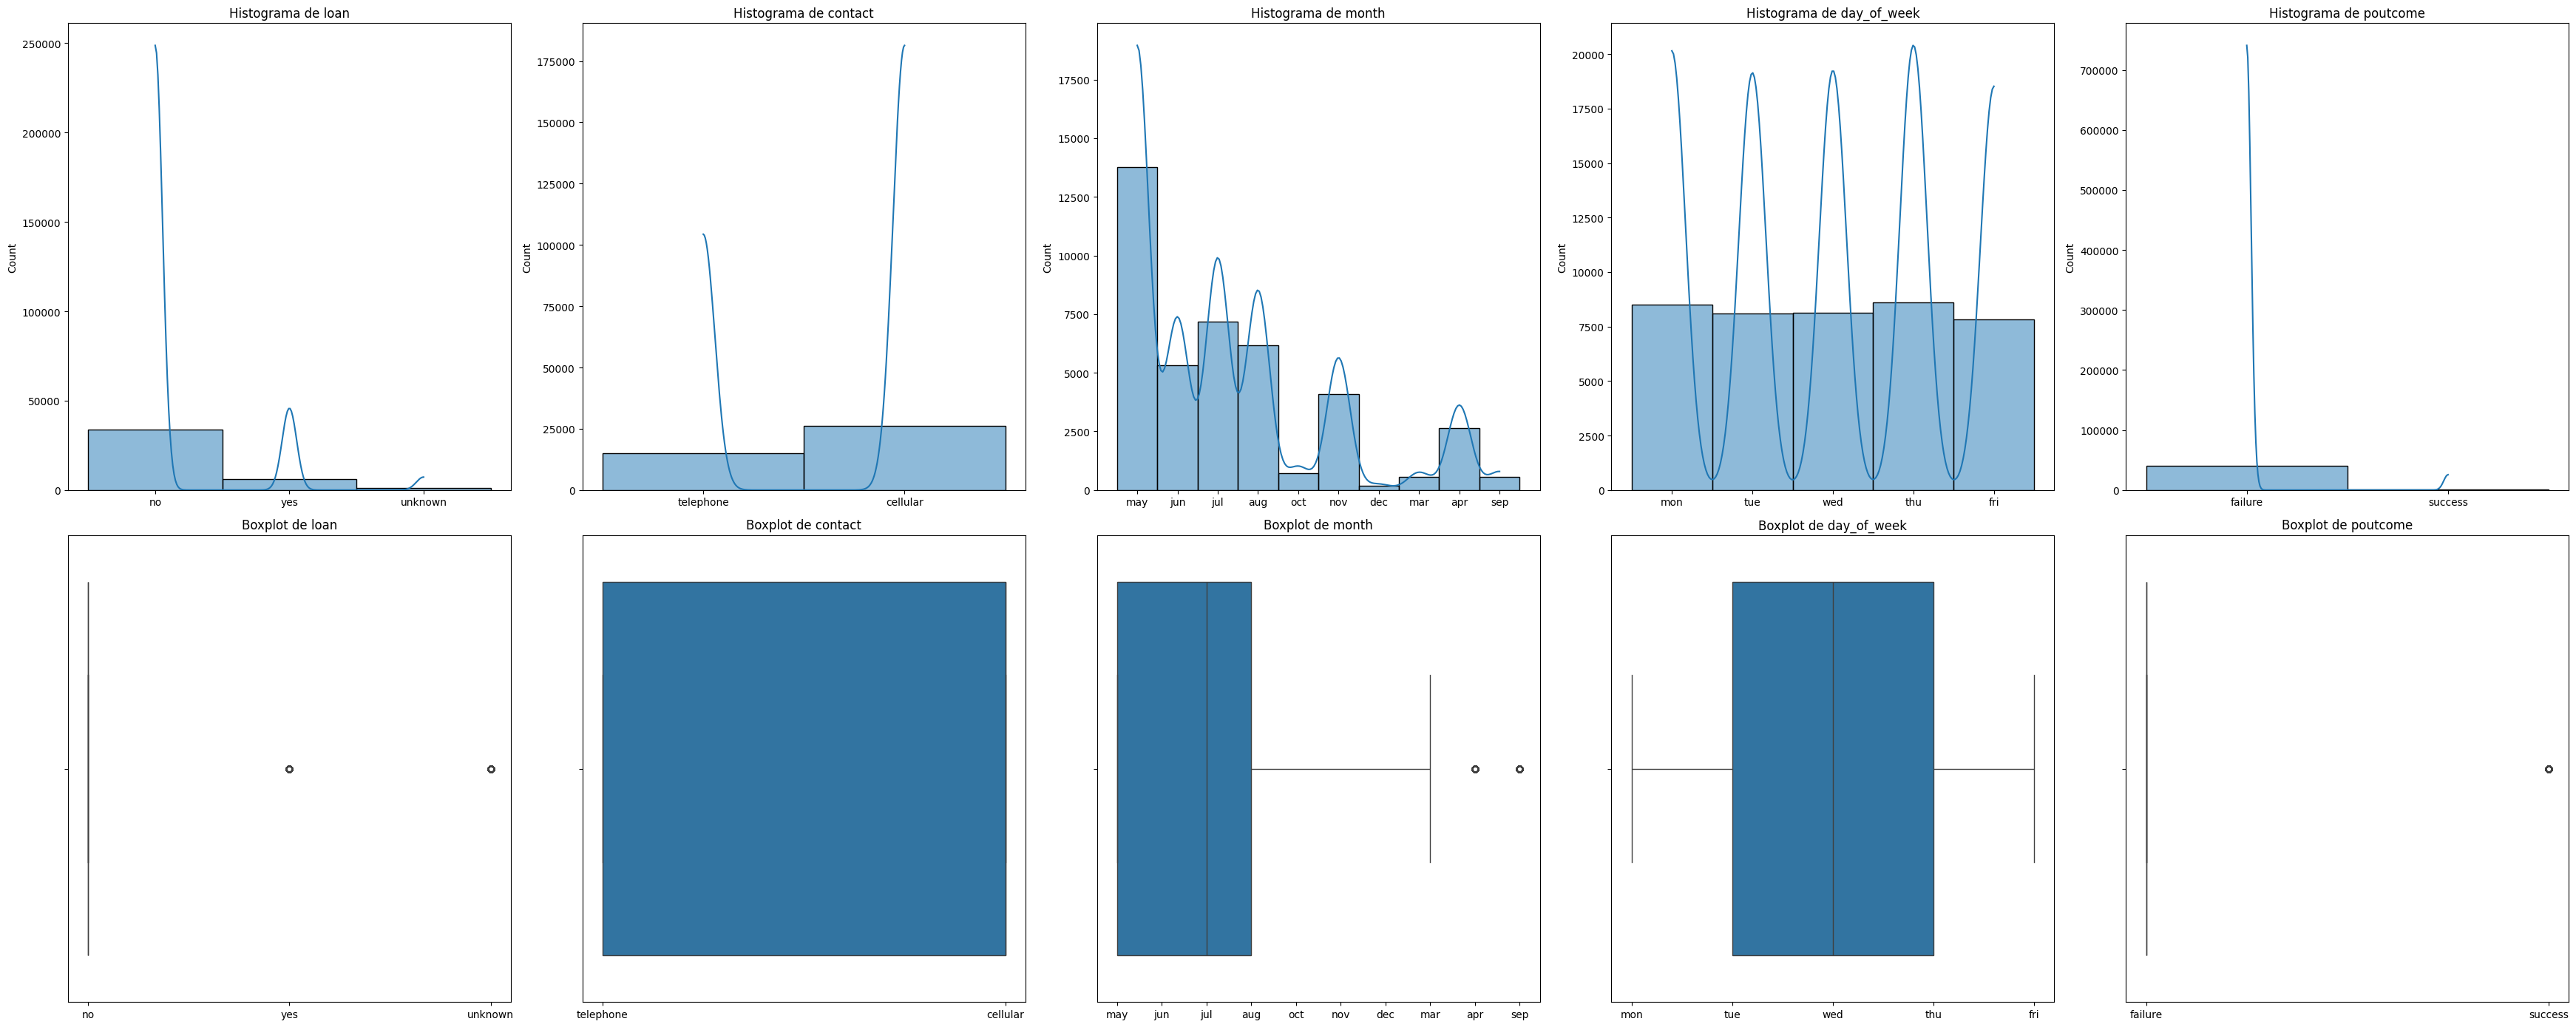

In [184]:
def graficar_categoricas(df, columnas):
   
    n = len(columnas)  
    n_columnas = 5 
    n_filas = 2  
    
    # Crear la figura con 2 filas y el número dinámico de columnas
    fig, axis = plt.subplots(n_filas, n_columnas, figsize=(n_columnas * 7, 2 * 7))  # 2 filas: histogramas y boxplots
    
    # Aplanar el array de ejes para facilitar la iteración
    axis = axis.flatten()
    
    # Graficar cada variable
    for i, col in enumerate(columnas):
        # Histograma (en la fila 0)
        sns.histplot(df[col], bins=30, kde=True, ax=axis[i]).set(xlabel=None)
        axis[i].set_title(f'Histograma de {col}')
        
        # Boxplot (en la fila 1)
        sns.boxplot(data=df, x=col, ax=axis[i + n_columnas]).set(xlabel=None)
        axis[i + n_columnas].set_title(f'Boxplot de {col}')
    
    # Ajustar el layout para evitar que se sobrepongan los gráficos
    plt.tight_layout()
    plt.show()

### Segmentar por "n_columns" para que salgan los hisplots/boxplots.

graficar_categoricas(data, col_categoricas[0:5])
graficar_categoricas(data, col_categoricas[5:10])

Con la representación de cada variable podemos determinar que:

-
-
-
-
-
-
-
-
-
-

Para poder ver las relaciones entre las variables numericas y la target(categorica), primero se factoriza la target. 

In [185]:
norm_target = "y_n"

data[norm_target] = pd.factorize(data["y"])[0]

target_rules = {row["y"]: row["y_n"] for _, row in data[["y", "y_n"]].drop_duplicates().iterrows()}

import json

with open("../models/target_rules.json", "w") as f:
  json.dump(target_rules, f)

data[norm_target]

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y_n, Length: 41188, dtype: int64

Analisis bivariante entre la target y variables numéricas. 

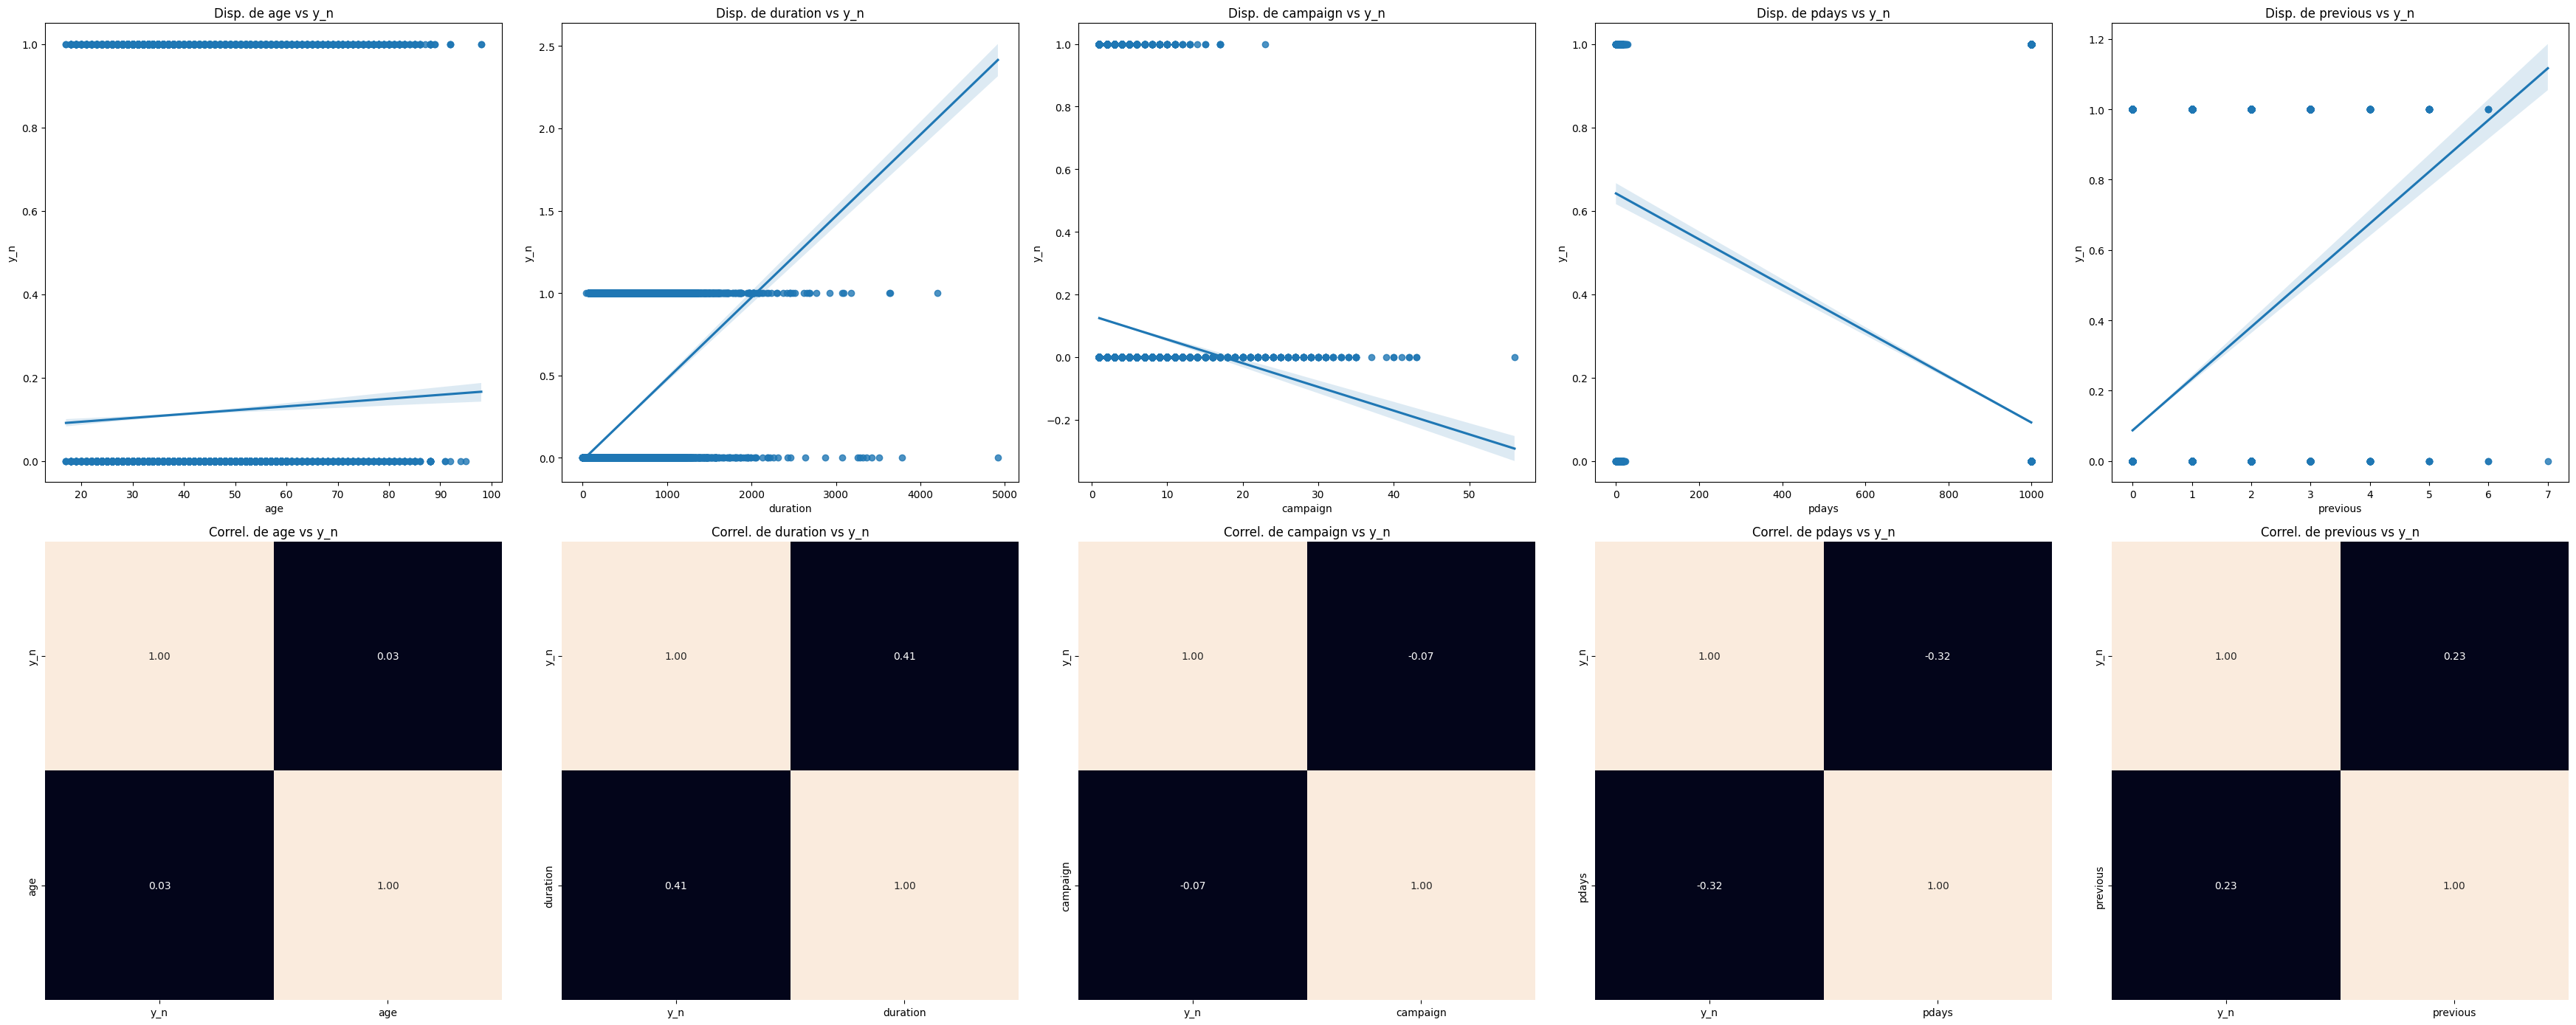

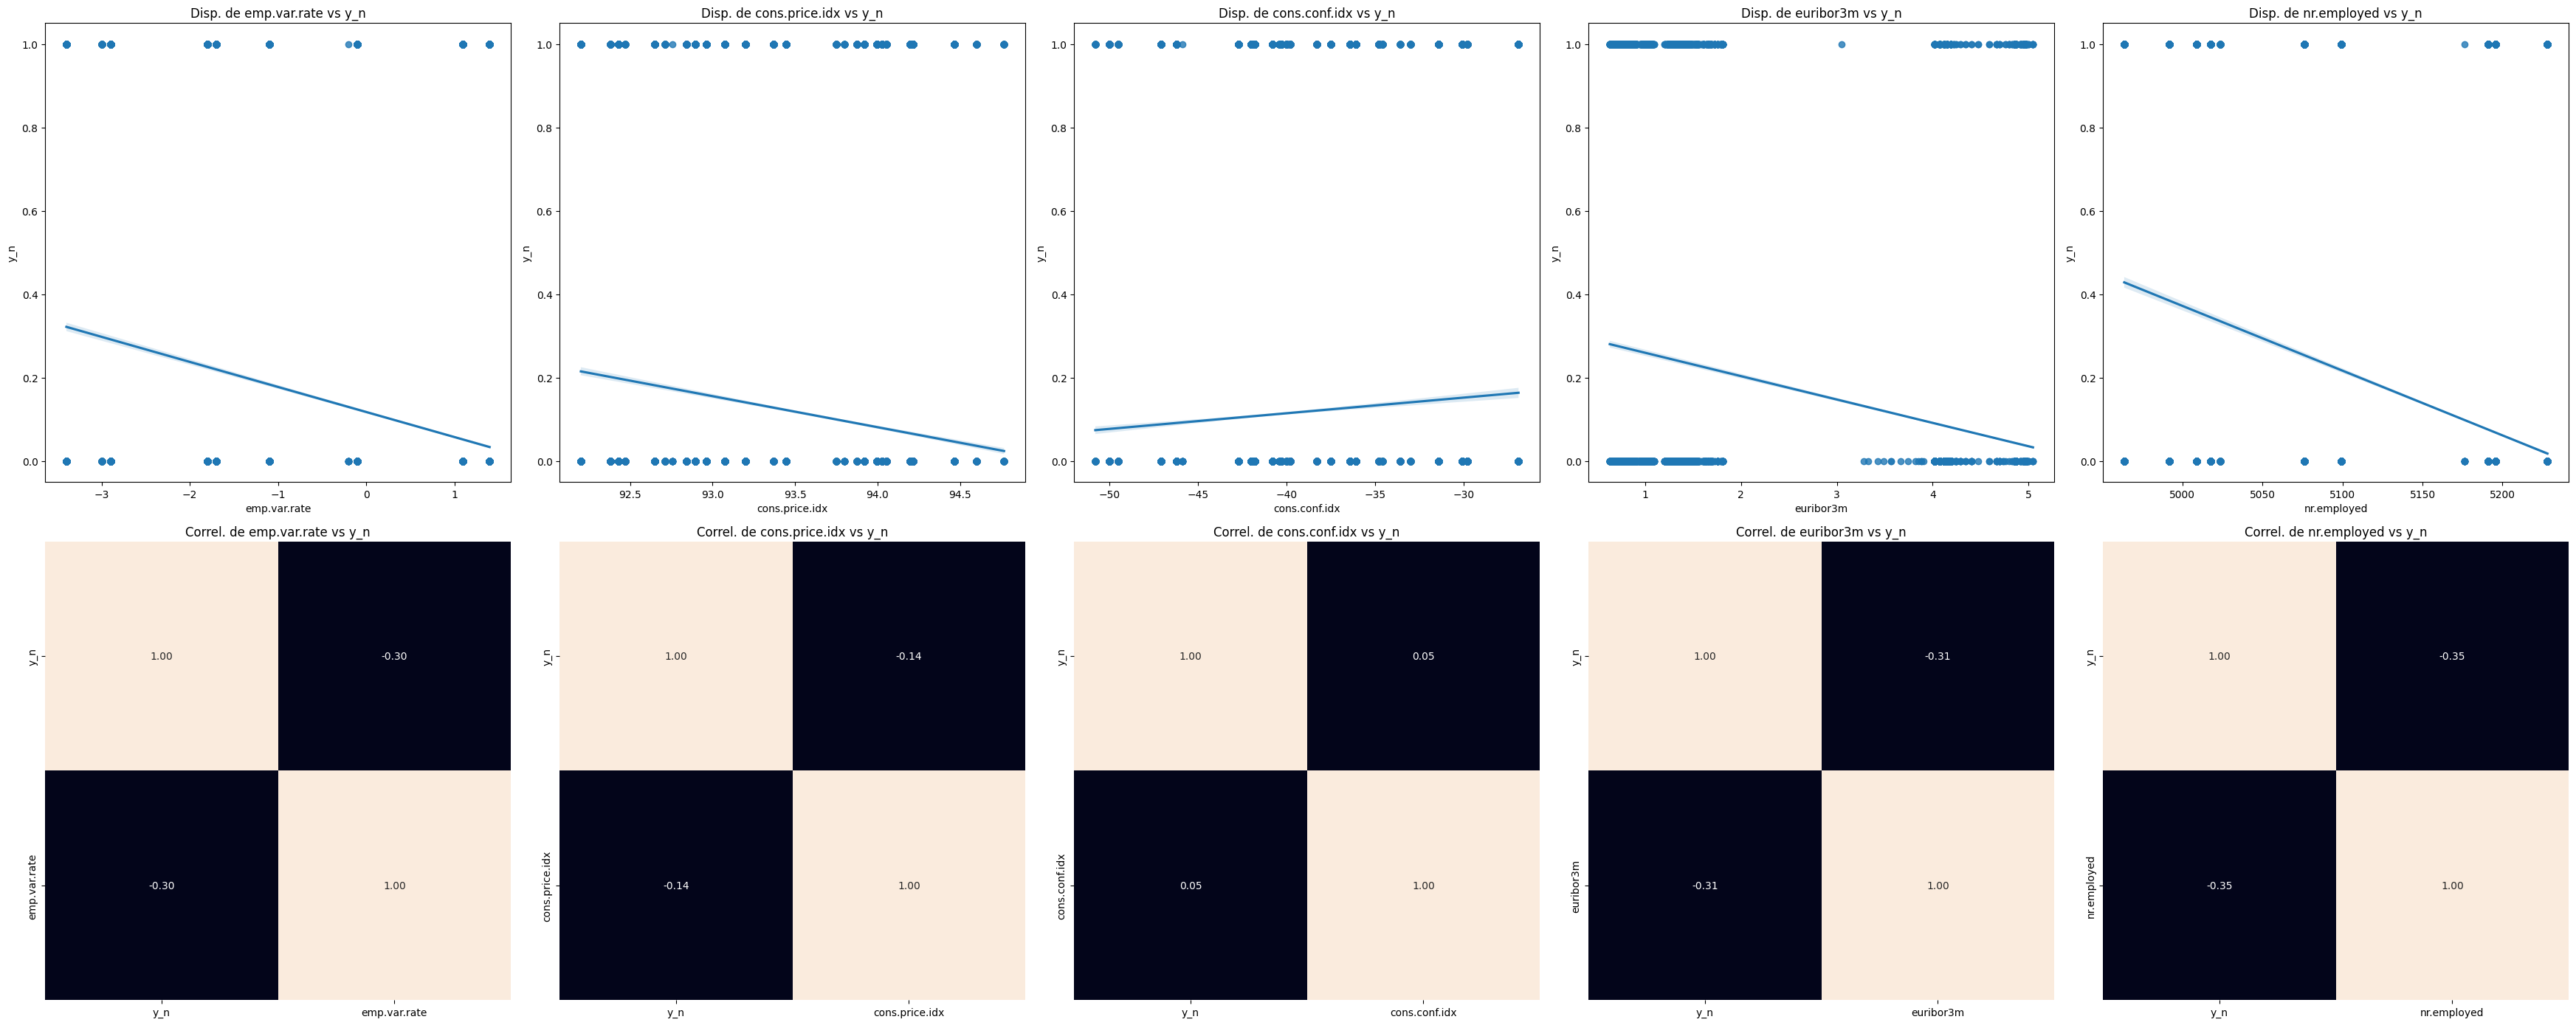

In [186]:
def graficar_dispersiones_y_heatmaps(df, columnas, target_col):
   
    n = len(columnas)  
    n_columnas = 5  
    n_filas = 2  
    
    # Crear la figura con el número dinámico de filas y columnas
    fig, axis = plt.subplots(n_filas, n_columnas, figsize=(n_columnas * 7, n_filas * 7))
    
    # Aplanar el array de ejes para facilitar la iteración
    axis = axis.flatten()
    
    # Graficar los gráficos de dispersión (regplot) y mapas de calor (heatmap)
    for i, col in enumerate(columnas):
        # Regplot (Gráfico de dispersión) en la fila 0
        sns.regplot(ax=axis[i], data=df, x=col, y=target_col)
        axis[i].set_title(f'Disp. de {col} vs {target_col}')
        
        # Heatmap de la correlación en la fila 1
        sns.heatmap(df[[target_col, col]].corr(), annot=True, fmt=".2f", ax=axis[i + n_columnas], cbar=False)
        axis[i + n_columnas].set_title(f'Correl. de {col} vs {target_col}')
    
    # Ajustar el layout para evitar que los gráficos se sobrepongan
    plt.tight_layout()
    plt.show()

### Segmentar por "n_columns" para que salgan los hisplots/boxplots.

graficar_dispersiones_y_heatmaps(data, col_numericas[0:5], norm_target)
graficar_dispersiones_y_heatmaps(data, col_numericas[5:10], norm_target)


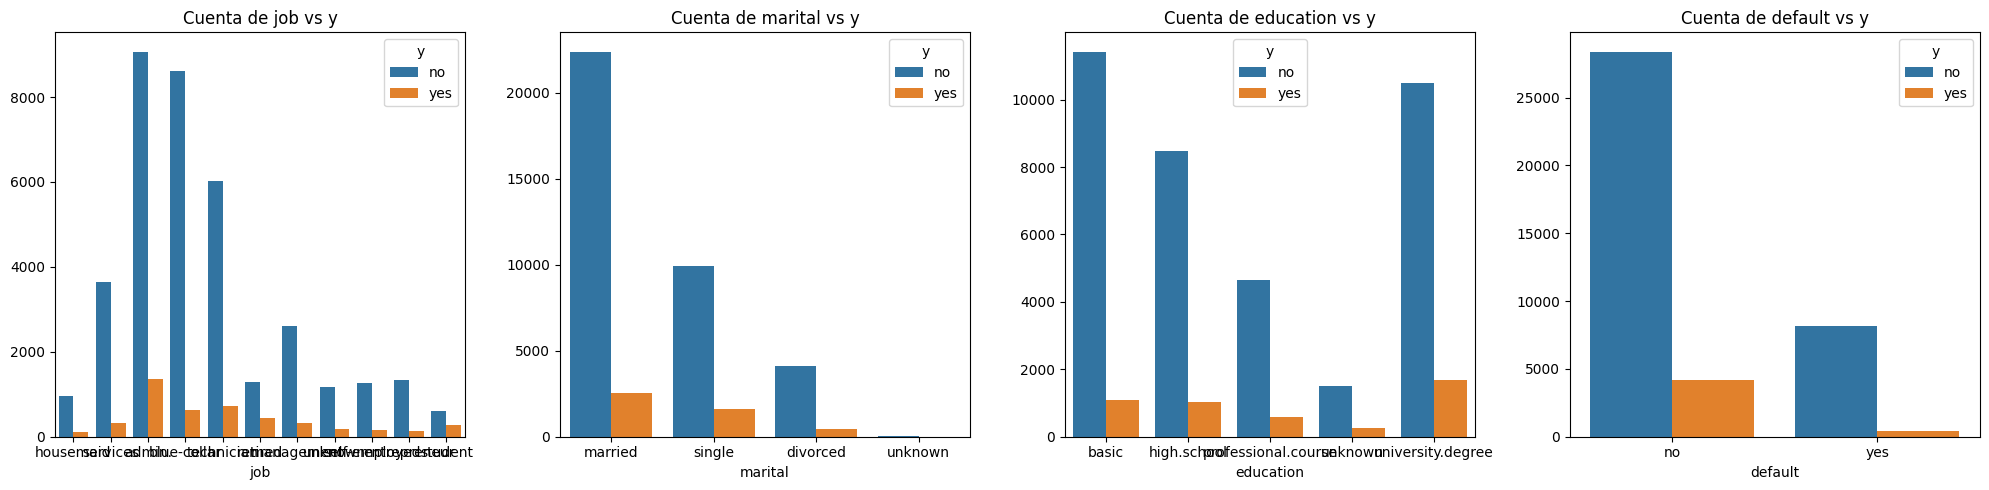

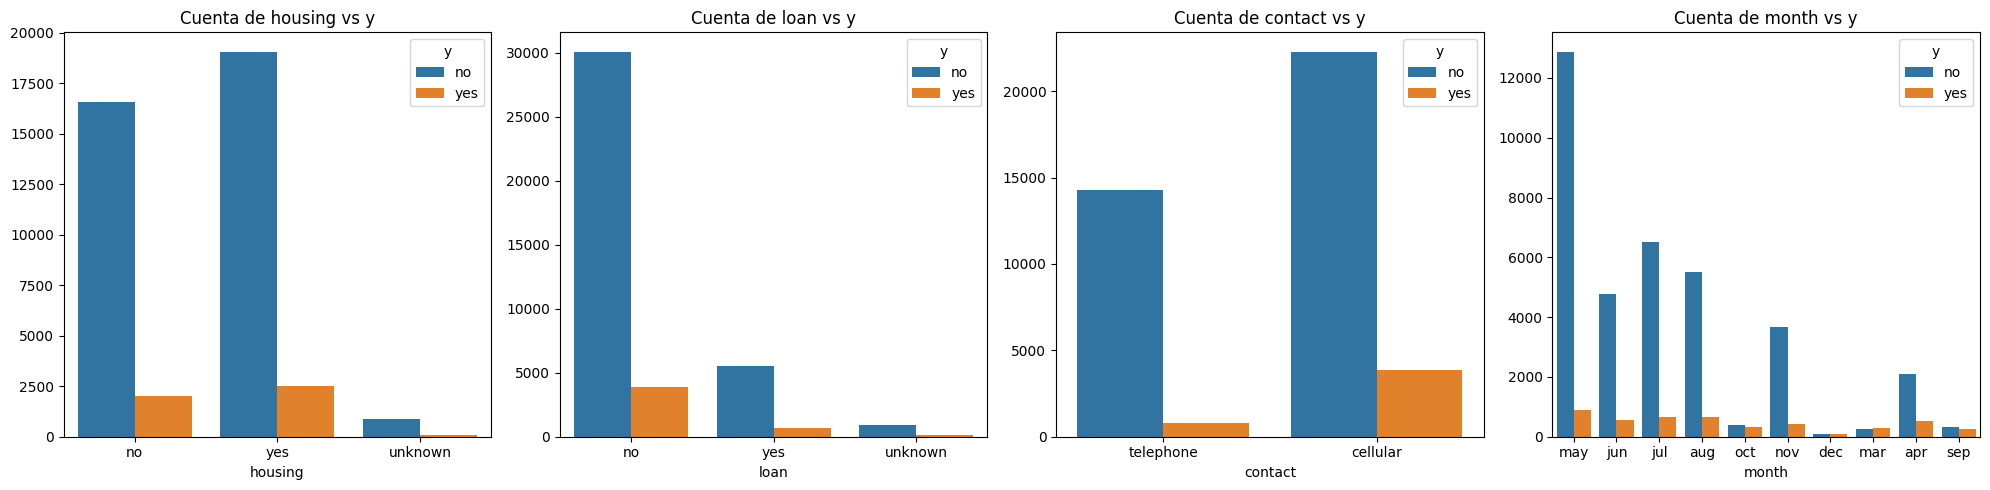

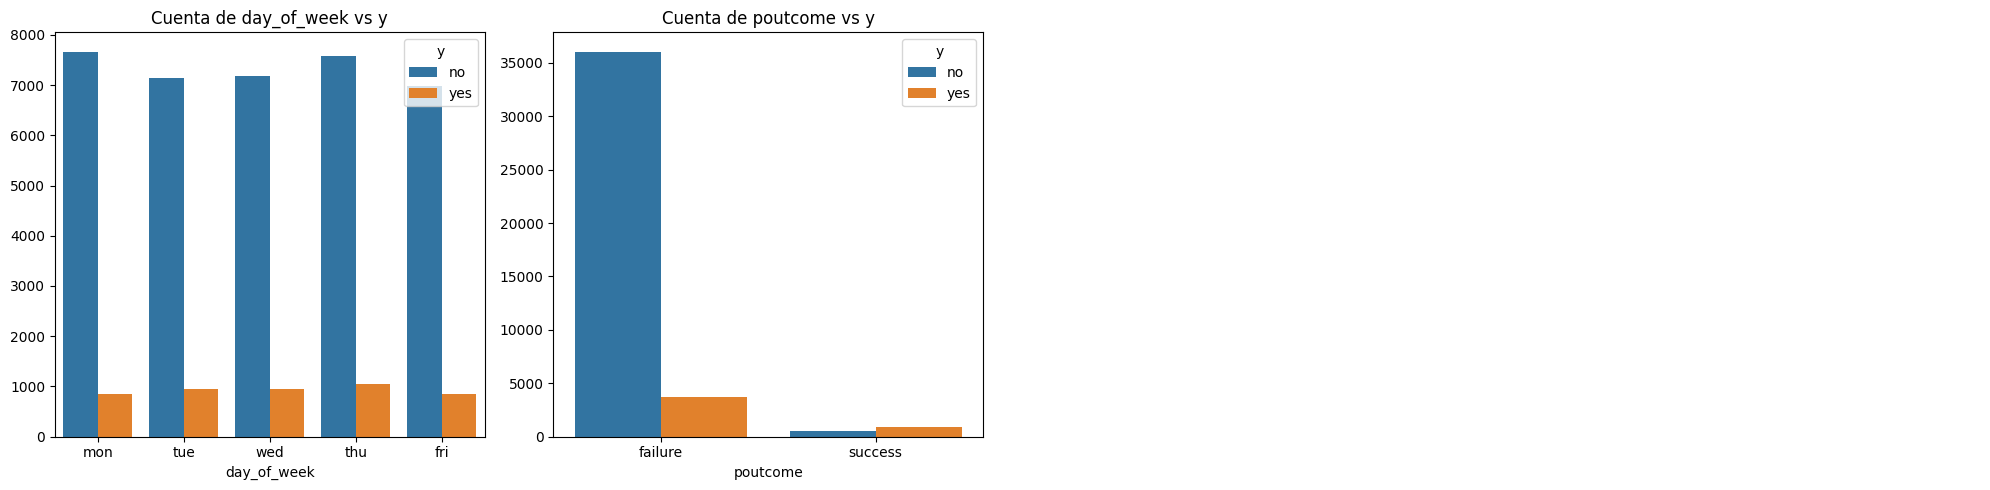

In [187]:
def graficar_countplots(df, columnas, target_col):
    
    n = len(columnas)  
    n_columnas = 4  
    n_filas = (n + n_columnas - 1) // n_columnas  
    
    # Crear la figura con el número dinámico de filas y columnas
    fig, axis = plt.subplots(n_filas, n_columnas, figsize=(n_columnas * 5, n_filas * 5))
    
    # Aplanar el array de ejes para facilitar la iteración
    axis = axis.flatten()
    
    # Graficar los countplots
    for i, col in enumerate(columnas):
        # Crear el gráfico de barras con el 'hue' basado en la columna objetivo
        sns.countplot(ax=axis[i], data=df, x=col, hue=target_col)
        axis[i].set_title(f'Cuenta de {col} vs {target_col}')
        axis[i].set_ylabel(None)  # Eliminar etiquetas de eje y, como en el ejemplo original
    
    # Si hay menos gráficos que subgráficos, ocultar los ejes restantes
    for j in range(i + 1, len(axis)):
        axis[j].axis('off')  # Ocultar los ejes vacíos
    
    # Ajustar el layout para evitar que se sobrepongan los gráficos
    plt.tight_layout()
    plt.show()

### Segmentar por "n_columns" para que salgan los hisplots/boxplots.

graficar_countplots(data, col_categoricas[0:4], "y")
graficar_countplots(data, col_categoricas[4:8], "y")
graficar_countplots(data, col_categoricas[8:10], "y")

Factorización de las variables categoricas para poder hacer el análisis de correlaciones. 

In [188]:
def automatizar_factorizacion(df, columnas):
   
    transformacion_reglas = {}
    col_factorizadas = []
    
    # Iterar sobre las columnas especificadas para la factorización
    for col in columnas:
        # Aplicar la factorización y agregar la columna al DataFrame
        df[f"{col}_n"] = pd.factorize(df[col])[0]
        
        # Agregar el nombre de la columna factorizada a la lista
        col_factorizadas.append(f"{col}_n")
        
        # Guardar las reglas de transformación para la columna actual en el diccionario
        transformacion_reglas[col] = {row[col]: row[f"{col}_n"] for _, row in df[[col, f"{col}_n"]].drop_duplicates().iterrows()}
    
    # Guardar el diccionario de reglas en un archivo JSON
    with open("../models/transformacion_reglas.json", "w") as f:
        json.dump(transformacion_reglas, f)
    
    print("Factorización completada y reglas guardadas en 'transformacion_reglas.json'.")
    
    # Retornar el DataFrame actualizado con las nuevas columnas numéricas y la lista de columnas factorizadas
    return df, col_factorizadas

# Llamar a la función para automatizar la factorización
data, col_factorizadas = automatizar_factorizacion(data, col_categoricas)

# Imprimir las columnas que han sido factorizadas
print("Columnas factorizadas:", col_factorizadas)

Factorización completada y reglas guardadas en 'transformacion_reglas.json'.
Columnas factorizadas: ['job_n', 'marital_n', 'education_n', 'default_n', 'housing_n', 'loan_n', 'contact_n', 'month_n', 'day_of_week_n', 'poutcome_n']


Análisis de correlacion numérico - numérico

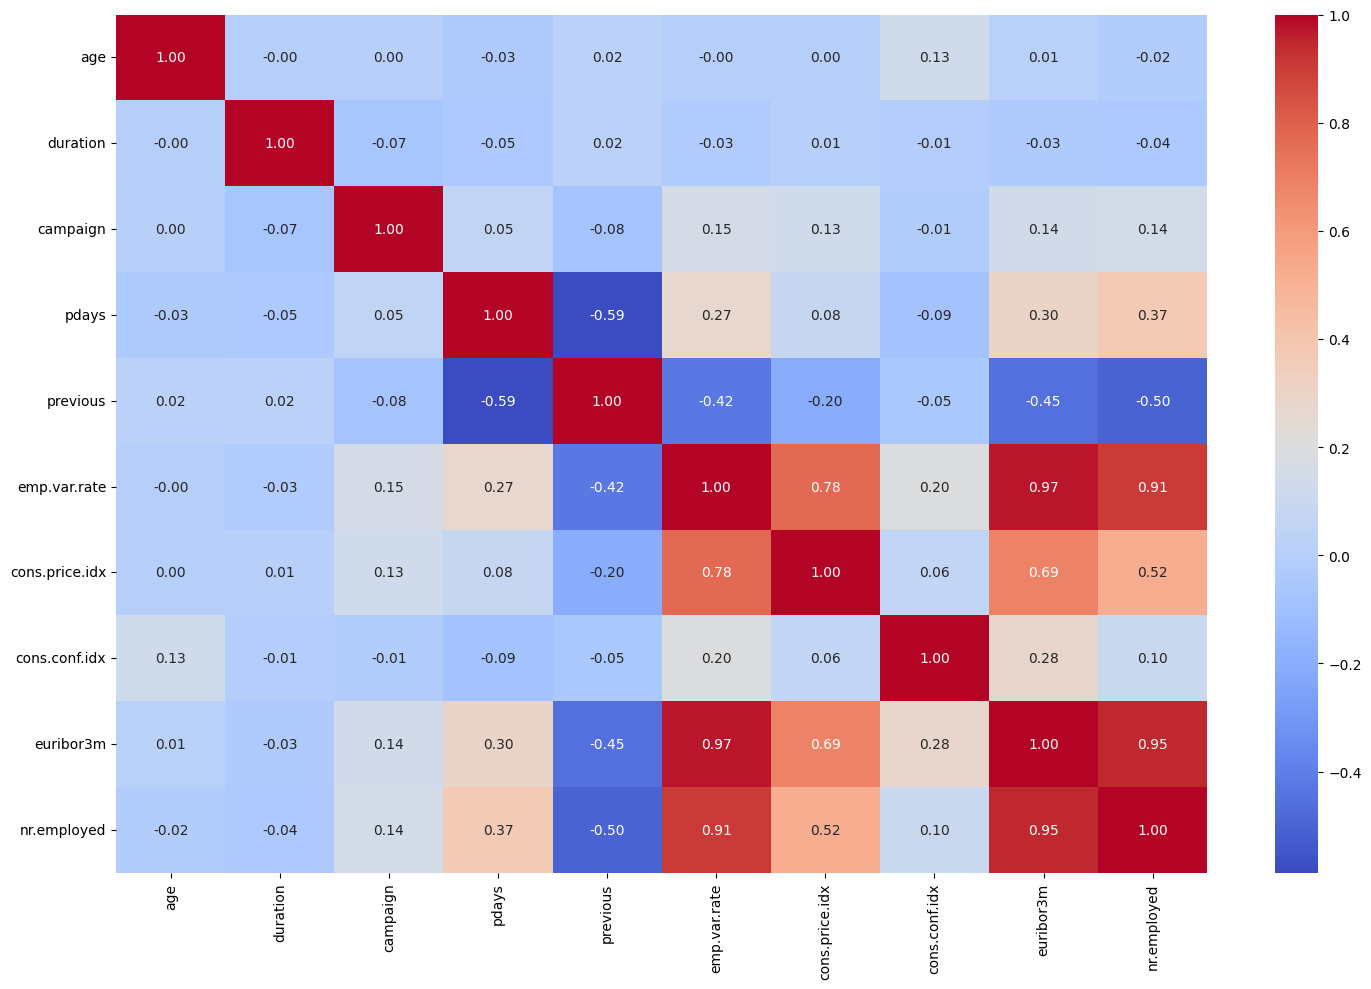

In [189]:
fig, axis = plt.subplots(figsize = (15, 10))

sns.heatmap(data[col_numericas].corr(), annot = True, fmt = ".2f", cmap = "coolwarm")

plt.tight_layout()

plt.show()

Análisis de correlacion numérico - categórico

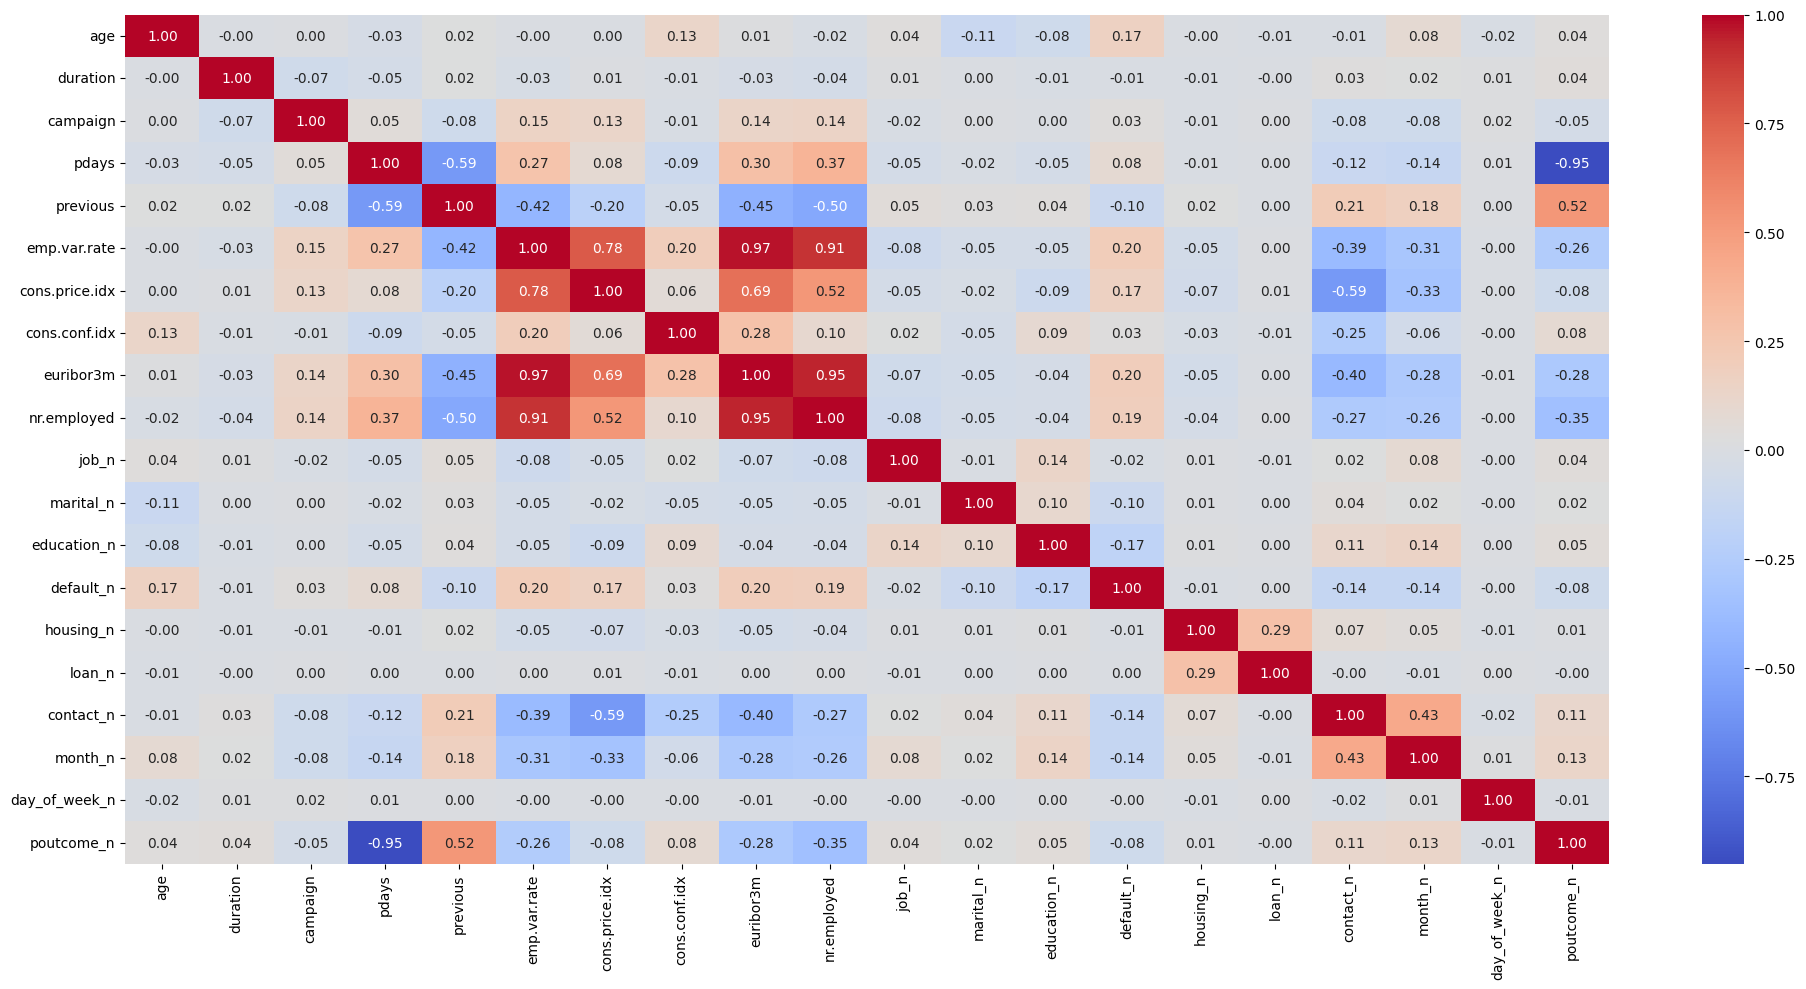

In [190]:
fig, axis = plt.subplots(figsize = (20, 10))

sns.heatmap(data[col_numericas + col_factorizadas].corr(), annot = True, fmt = ".2f", cmap = "coolwarm")

plt.tight_layout()

plt.show()

In [191]:

# import matplotlib.pyplot as plt
# import seaborn as sns

# Mapa de calor de la matriz de correlación
# plt.figure(figsize=(20, 20))
# sns.heatmap(data[col_numericas].corr(), annot=True, fmt='.2f', cmap="coolwarm")

# Gráficos de barras
# plt.figure(figsize=(30, 30))  
# for i, col in enumerate(data.columns.tolist(), 1):
#     plt.subplot(4, 2, i)
#     sns.countplot(data=data, x="y", hue=col, palette="coolwarm")
#     plt.title(f"Count Plot of y with hue {col}")

# plt.tight_layout()
# plt.show()

In [192]:
# def create_count_plots(customer_data, cat_dimensions):
#     plt.figure(figsize=(20, 20))  # Adjust figure size
#     for i, col in enumerate(cat_dimensions, 1):
#         plt.subplot(6, 2, i)  # Create a subplot for each category dimension
#         sns.countplot(data=customer_data, x="y", hue=col, palette="coolwarm")
#         plt.title(f"Count Plot of y with hue {col}")
#     plt.tight_layout()  # Ensure the plots are well spaced
#     plt.show()

# create_count_plots(data, )

Dataset factorizado

In [193]:
n_data = data.drop(columns= col_categoricas + target)
n_data

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,0,0,0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,1,1,0,0,0,0,0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,1,0,1,0,0,0,0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,2,0,0,0,0,0,0,0,0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,5,0,2,0,1,0,1,5,4,0
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,3,0,2,0,0,0,1,5,4,0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,5,0,4,0,1,0,1,5,4,0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,4,0,2,0,0,0,1,5,4,0


In [194]:
n_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,...,3.601073,0.510634,1.794697,0.208799,0.571914,0.199767,0.634748,2.250097,1.979581,0.033335
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,...,2.275255,0.696779,1.621205,0.406455,0.541209,0.456002,0.481507,2.429079,1.411514,0.179512
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,...,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,2.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,...,4.000000,1.000000,4.000000,0.000000,1.000000,0.000000,1.000000,3.000000,3.000000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,...,10.000000,3.000000,4.000000,1.000000,2.000000,2.000000,1.000000,9.000000,4.000000,1.000000


In [195]:
n_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   duration        41188 non-null  int64  
 2   campaign        41188 non-null  int64  
 3   pdays           41188 non-null  int64  
 4   previous        41188 non-null  int64  
 5   emp.var.rate    41188 non-null  float64
 6   cons.price.idx  41188 non-null  float64
 7   cons.conf.idx   41188 non-null  float64
 8   euribor3m       41188 non-null  float64
 9   nr.employed     41188 non-null  float64
 10  y_n             41188 non-null  int64  
 11  job_n           41188 non-null  int64  
 12  marital_n       41188 non-null  int64  
 13  education_n     41188 non-null  int64  
 14  default_n       41188 non-null  int64  
 15  housing_n       41188 non-null  int64  
 16  loan_n          41188 non-null  int64  
 17  contact_n       41188 non-null 

Analisis Outliers 

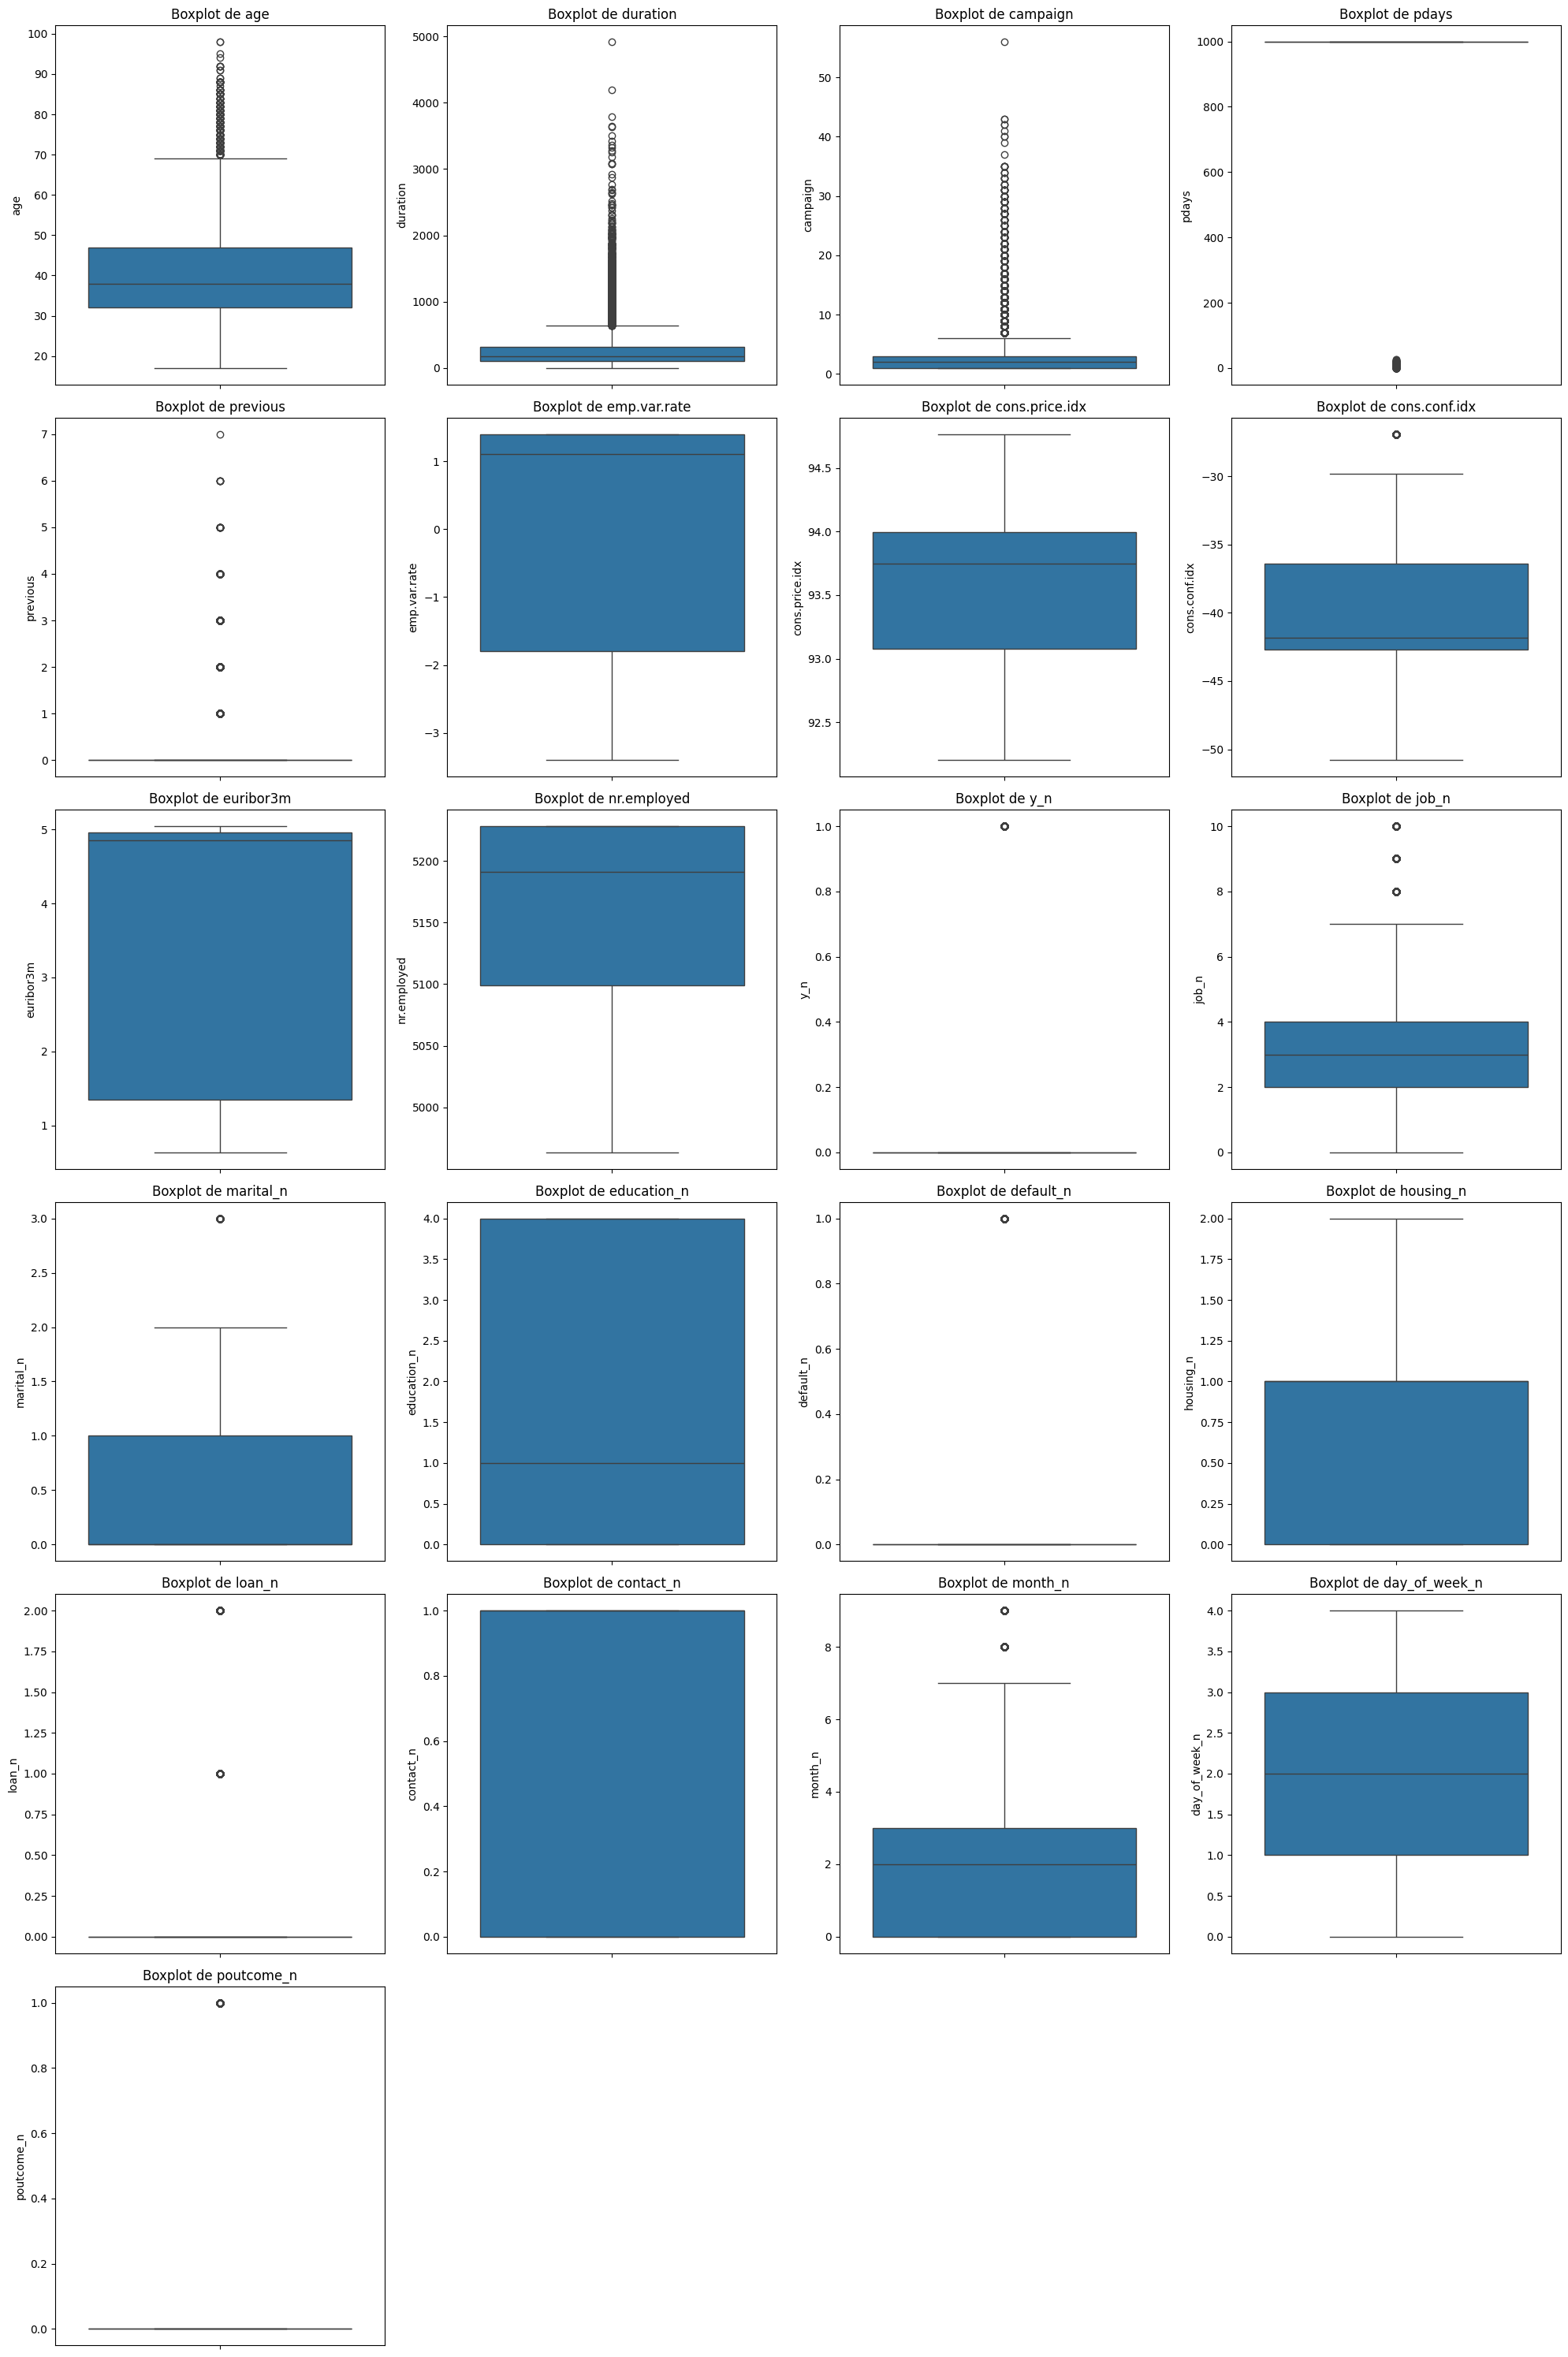

In [196]:
def generar_boxplots_automaticos(df):
   
    # Filtrar las columnas numéricas del DataFrame, como ya esta normalizado, son todas. 
    columnas = df.columns

    n_columnas = 4
    n_filas = (len(columnas) + n_columnas - 1) // n_columnas  # Redondeo hacia arriba

    # Crear la figura y los ejes para los subgráficos
    fig, axis = plt.subplots(n_filas, n_columnas, figsize=(n_columnas * 5, n_filas * 5))

    # Aplanar el array de ejes para facilitar la iteración
    axis = axis.flatten()

    # Graficar un boxplot para cada columna del DataFrame
    for i, col in enumerate(columnas):
        sns.boxplot(ax=axis[i], data=df, y=col)
        axis[i].set_title(f'Boxplot de {col}')

    # Si hay menos gráficos que subgráficos, ocultar los ejes restantes
    for j in range(i + 1, len(axis)):
        axis[j].axis('off')

    # Ajustar el layout para evitar que los gráficos se sobrepongan
    plt.tight_layout()
    plt.show()

generar_boxplots_automaticos(n_data)

Resumen outliers: 

In [197]:
# outlier_columns = []
# for column in df.select_dtypes(include=['float64', 'int64']).columns:
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Check if there are any outliers in the column
#     if df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0] > 0:
#         outlier_columns.append(column)

# print(f"Columns with outliers based on IQR method: {outlier_columns}")

In [198]:
# for column in outlier_columns:
#     # Calculate Q1 (25th percentile) and Q3 (75th percentile)
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR


#     df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# print(f"Data shape after removing outliers: {df.shape}")

In [199]:
# Replace 'unknown' with NaN in the relevant columns

# df[['job', 'marital', 'education', 'housing', 'loan']] = df[['job', 'marital', 'education', 'housing', 'loan']].replace('unknown', np.nan)
# df.isnull().sum().sum()
# 3735
# Impute missing values with the mode (most frequent value) for categorical columns

# df['job'].fillna(df['job'].mode()[0], inplace=True)
# df['marital'].fillna(df['marital'].mode()[0], inplace=True)
# df['education'].fillna(df['education'].mode()[0], inplace=True)
# df['housing'].fillna(df['housing'].mode()[0], inplace=True)
# df['loan'].fillna(df['loan'].mode()[0], inplace=True)
# df.isnull().sum().sum()
# 0

Reemplazar outliers 

In [200]:
import os 

total_data_con_outliers = n_data.copy() 
total_data_sin_outliers = n_data.copy()

col_con_outliers = ["age", "duration", "campaign", "pdays", "job_n", "poutcome_n", "loan_n", "default_n", "previous", "month_n"] # añadir outliers

def replace_outliers_from_column(column, df):
  column_stats = df[column].describe()
  column_iqr = column_stats["75%"] - column_stats["25%"]
  upper_limit = column_stats["75%"] + 1.5 * column_iqr
  lower_limit = column_stats["25%"] - 1.5 * column_iqr
  if lower_limit < 0: lower_limit = min(df[column])
  # Remove upper outliers
  df[column] = df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
  # Remove lower outliers
  df[column] = df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
  return df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in col_con_outliers:
  total_data_sin_outliers, limits_list = replace_outliers_from_column(column, total_data_sin_outliers)
  outliers_dict[column] = limits_list

with open("../models/outliers_replacement.json", "w") as f:
  json.dump(outliers_dict, f)

outliers_dict

{'age': [np.float64(9.5), np.float64(69.5)],
 'duration': [0, np.float64(644.5)],
 'campaign': [1, np.float64(6.0)],
 'pdays': [np.float64(999.0), np.float64(999.0)],
 'job_n': [0, np.float64(7.0)],
 'poutcome_n': [np.float64(0.0), np.float64(0.0)],
 'loan_n': [np.float64(0.0), np.float64(0.0)],
 'default_n': [np.float64(0.0), np.float64(0.0)],
 'previous': [np.float64(0.0), np.float64(0.0)],
 'month_n': [0, np.float64(7.5)]}

In [201]:
total_data_con_outliers.isnull().sum().sort_values(ascending=False)

age               0
job_n             0
day_of_week_n     0
month_n           0
contact_n         0
loan_n            0
housing_n         0
default_n         0
education_n       0
marital_n         0
y_n               0
duration          0
nr.employed       0
euribor3m         0
cons.conf.idx     0
cons.price.idx    0
emp.var.rate      0
previous          0
pdays             0
campaign          0
poutcome_n        0
dtype: int64

In [202]:
total_data_sin_outliers

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n
0,56.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0
1,57.0,149.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,1.0,0,1,0.0,0,0.0,0,0.0,0,0.0
2,37.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,1.0,0,1,0.0,1,0.0,0,0.0,0,0.0
3,40.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,2.0,0,0,0.0,0,0.0,0,0.0,0,0.0
4,56.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,1.0,0,1,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,69.5,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,5.0,0,2,0.0,1,0.0,1,5.0,4,0.0
41184,46.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,3.0,0,2,0.0,0,0.0,1,5.0,4,0.0
41185,56.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,5.0,0,4,0.0,1,0.0,1,5.0,4,0.0
41186,44.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,4.0,0,2,0.0,0,0.0,1,5.0,4,0.0


NO hay valores nulos

Unificar variables. 

In [203]:
# from sklearn.preprocessing import MinMaxScaler

# def normalize_and_create(data, columns_to_normalize, new_column_name='prev_camp'):

#     # Crear un objeto MinMaxScaler
#     scaler = MinMaxScaler()

#     # Normalizar las columnas especificadas
#     data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

#     # Crear la nueva variable 'risk' como la media de las columnas normalizadas
#     data[new_column_name] = data[columns_to_normalize].mean(axis=1)

#     return data

# # Definir las columnas que se van a normalizar
# columns_to_normalize_prev_camp = ['previous', 'poutcome_n']

# # Normalizar y crear la variable 'risk' para el conjunto con outliers
# total_data_con_outliers = normalize_and_create(total_data_con_outliers, columns_to_normalize_prev_camp)

# # Normalizar y crear la variable 'risk' para el conjunto sin outliers
# total_data_sin_outliers = normalize_and_create(total_data_sin_outliers, columns_to_normalize_prev_camp)


In [204]:
from sklearn.preprocessing import MinMaxScaler

def normalize_and_create(data, columns_to_normalize, new_column_name='econ_index'):

    # Crear un objeto MinMaxScaler
    scaler = MinMaxScaler()

    # Normalizar las columnas especificadas
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

    # Crear la nueva variable 'risk' como la media de las columnas normalizadas
    data[new_column_name] = data[columns_to_normalize].mean(axis=1)

    return data

# Definir las columnas que se van a normalizar
columns_to_normalize_econ_index = ['emp.var.rate', 'euribor3m', 'nr.employed']

# Normalizar y crear la variable 'risk' para el conjunto con outliers
total_data_con_outliers = normalize_and_create(total_data_con_outliers, columns_to_normalize_econ_index)

# Normalizar y crear la variable 'risk' para el conjunto sin outliers
total_data_sin_outliers = normalize_and_create(total_data_sin_outliers, columns_to_normalize_econ_index)

In [205]:
# from sklearn.preprocessing import MinMaxScaler

# def normalize_and_create(data, columns_to_normalize, new_column_name='has_loan'):

#     # Crear un objeto MinMaxScaler
#     scaler = MinMaxScaler()

#     # Normalizar las columnas especificadas
#     data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

#     # Crear la nueva variable 'risk' como la media de las columnas normalizadas
#     data[new_column_name] = data[columns_to_normalize].mean(axis=1)

#     return data

# # Definir las columnas que se van a normalizar
# columns_to_normalize_has_loan = ['housing_n', 'loan_n']

# # Normalizar y crear la variable 'risk' para el conjunto con outliers
# total_data_con_outliers = normalize_and_create(total_data_con_outliers, columns_to_normalize_has_loan)

# # Normalizar y crear la variable 'risk' para el conjunto sin outliers
# total_data_sin_outliers = normalize_and_create(total_data_sin_outliers, columns_to_normalize_has_loan)

Eliminar del dataset las columnas ya unificadas 

In [206]:
total_data_con_outliers.drop(columns_to_normalize_econ_index, axis= 1, inplace= True)
total_data_sin_outliers.drop(columns_to_normalize_econ_index, axis= 1, inplace= True)

In [207]:
total_data_sin_outliers

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,y_n,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n,econ_index
0,56.0,261.0,1.0,999.0,0.0,93.994,-36.4,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.918205
1,57.0,149.0,1.0,999.0,0.0,93.994,-36.4,0,1.0,0,1,0.0,0,0.0,0,0.0,0,0.0,0.918205
2,37.0,226.0,1.0,999.0,0.0,93.994,-36.4,0,1.0,0,1,0.0,1,0.0,0,0.0,0,0.0,0.918205
3,40.0,151.0,1.0,999.0,0.0,93.994,-36.4,0,2.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.918205
4,56.0,307.0,1.0,999.0,0.0,93.994,-36.4,0,1.0,0,1,0.0,0,0.0,0,0.0,0,0.0,0.918205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,69.5,334.0,1.0,999.0,0.0,94.767,-50.8,1,5.0,0,2,0.0,1,0.0,1,5.0,4,0.0,0.189496
41184,46.0,383.0,1.0,999.0,0.0,94.767,-50.8,0,3.0,0,2,0.0,0,0.0,1,5.0,4,0.0,0.189496
41185,56.0,189.0,2.0,999.0,0.0,94.767,-50.8,0,5.0,0,4,0.0,1,0.0,1,5.0,4,0.0,0.189496
41186,44.0,442.0,1.0,999.0,0.0,94.767,-50.8,1,4.0,0,2,0.0,0,0.0,1,5.0,4,0.0,0.189496


In [208]:
total_data_con_outliers.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'y_n', 'job_n', 'marital_n', 'education_n',
       'default_n', 'housing_n', 'loan_n', 'contact_n', 'month_n',
       'day_of_week_n', 'poutcome_n', 'econ_index'],
      dtype='object')>

SPLIT

In [209]:
from sklearn.model_selection import train_test_split

num_variables = total_data_con_outliers.copy().drop("y_n", axis= 1).columns.tolist()

# Dividimos el conjunto de datos en muestras de train y test
X_con_outliers = total_data_con_outliers.drop("y_n", axis = 1)[num_variables]
X_sin_outliers = total_data_sin_outliers.drop("y_n", axis = 1)[num_variables]
y = total_data_con_outliers["y_n"]

X_train_con_outliers, X_test_con_outliers, y_train, y_test = train_test_split(X_con_outliers, y, test_size = 0.2, random_state = 42)
X_train_sin_outliers, X_test_sin_outliers = train_test_split(X_sin_outliers, test_size = 0.2, random_state = 42)

# GUARDAR LOS DATASETS
X_train_con_outliers.to_excel("../data/processed/X_train_con_outliers.xlsx", index = False)
X_train_sin_outliers.to_excel("../data/processed/X_train_sin_outliers.xlsx", index = False)
X_test_con_outliers.to_excel("../data/processed/X_test_con_outliers.xlsx", index = False)
X_test_sin_outliers.to_excel("../data/processed/X_test_sin_outliers.xlsx", index = False)
y_train.to_excel("../data/processed/y_train.xlsx", index = False)
y_test.to_excel("../data/processed/y_test.xlsx", index = False)

X_train_con_outliers.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n,econ_index
12556,40,94,2,999,0,93.918,-42.7,3,0,0,1,1,0,0,2,0,0,0.993577
35451,31,116,4,999,0,92.893,-46.2,2,0,4,0,0,0,1,0,0,0,0.327970
30592,59,13,6,999,1,92.893,-46.2,5,0,0,0,0,0,1,0,0,0,0.336283
17914,43,94,5,999,0,93.918,-42.7,0,2,0,0,1,0,1,2,1,0,0.993652
3315,39,344,2,999,0,93.994,-36.4,2,1,1,1,0,0,0,0,3,0,0.918432


ESCALADOS

In [210]:
from sklearn.preprocessing import StandardScaler
import pickle

### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
normalizador_con_outliers = StandardScaler()
normalizador_con_outliers.fit(X_train_con_outliers)

with open("../models/normalizador_con_outliers.pkl", "wb") as file:
  pickle.dump(normalizador_con_outliers, file)

X_train_con_outliers_norm = normalizador_con_outliers.transform(X_train_con_outliers)
X_train_con_outliers_norm = pd.DataFrame(X_train_con_outliers_norm, index = X_train_con_outliers.index, columns = num_variables)

X_test_con_outliers_norm = normalizador_con_outliers.transform(X_test_con_outliers)
X_test_con_outliers_norm = pd.DataFrame(X_test_con_outliers_norm, index = X_test_con_outliers.index, columns = num_variables)

# GUARDAR LOS DATASETS
X_train_con_outliers_norm.to_excel("../data/processed/X_train_con_outliers_norm.xlsx", index = False)
X_test_con_outliers_norm.to_excel("../data/processed/X_test_con_outliers_norm.xlsx", index = False)

### NORMALIZAMOS EL DATAFRAME SIN OUTLIERS Y LO GUARDAMOS
normalizador_sin_outliers = StandardScaler()
normalizador_sin_outliers.fit(X_train_sin_outliers)

with open("../models/normalizador_sin_outliers.pkl", "wb") as file:
  pickle.dump(normalizador_sin_outliers, file)

X_train_sin_outliers_norm = normalizador_sin_outliers.transform(X_train_sin_outliers)
X_train_sin_outliers_norm = pd.DataFrame(X_train_sin_outliers_norm, index = X_train_sin_outliers.index, columns = num_variables)

X_test_sin_outliers_norm = normalizador_sin_outliers.transform(X_test_sin_outliers)
X_test_sin_outliers_norm = pd.DataFrame(X_test_sin_outliers_norm, index = X_test_sin_outliers.index, columns = num_variables)

# GUARDAR LOS DATASETS
X_train_sin_outliers_norm.to_excel("../data/processed/X_train_sin_outliers_norm.xlsx", index = False)
X_test_sin_outliers_norm.to_excel("../data/processed/X_test_sin_outliers_norm.xlsx", index = False)

X_train_con_outliers_norm.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n,econ_index
12556,-0.001669,-0.631114,-0.206242,0.194661,-0.350902,0.589080,-0.472769,-0.260598,-0.738185,-1.107920,1.950181,0.787712,-0.438945,-1.319656,-0.104938,-1.402425,-0.184965,0.828434
35451,-0.864095,-0.546321,0.513676,0.194661,-0.350902,-1.180760,-1.229916,-0.699209,-0.738185,1.358615,-0.512773,-1.056870,-0.438945,0.757773,-0.929383,-1.402425,-0.184965,-1.218443
30592,1.819007,-0.943306,1.233593,0.194661,1.677559,-1.180760,-1.229916,0.616625,-0.738185,-1.107920,-0.512773,-1.056870,-0.438945,0.757773,-0.929383,-1.402425,-0.184965,-1.192880
17914,0.285806,-0.631114,0.873635,0.194661,-0.350902,0.589080,-0.472769,-1.576433,2.126401,-1.107920,-0.512773,0.787712,-0.438945,0.757773,-0.104938,-0.693804,-0.184965,0.828667
3315,-0.097494,0.332441,-0.206242,0.194661,-0.350902,0.720307,0.890097,-0.699209,0.694108,-0.491286,1.950181,-1.056870,-0.438945,-1.319656,-0.929383,0.723439,-0.184965,0.597347


In [211]:
from sklearn.preprocessing import MinMaxScaler

### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
scaler_con_outliers = MinMaxScaler()
scaler_con_outliers.fit(X_train_con_outliers)

with open("../models/scaler_con_outliers.pkl", "wb") as file:
  pickle.dump(scaler_con_outliers, file)

X_train_con_outliers_scal = scaler_con_outliers.transform(X_train_con_outliers)
X_train_con_outliers_scal = pd.DataFrame(X_train_con_outliers_scal, index = X_train_con_outliers.index, columns = num_variables)

X_test_con_outliers_scal = scaler_con_outliers.transform(X_test_con_outliers)
X_test_con_outliers_scal = pd.DataFrame(X_test_con_outliers_scal, index = X_test_con_outliers.index, columns = num_variables)

# GUARDAR LOS DATASETS
X_train_con_outliers_scal.to_excel("../data/processed/X_train_con_outliers_scal.xlsx", index = False)
X_test_con_outliers_scal.to_excel("../data/processed/X_test_con_outliers_scal.xlsx", index = False)

### ESCALAMOS EL DATAFRAME SIN OUTLIERS Y LO GUARDAMOS
scaler_sin_outliers = MinMaxScaler()
scaler_sin_outliers.fit(X_train_sin_outliers)

with open("../models/scaler_sin_outliers.pkl", "wb") as file:
  pickle.dump(scaler_sin_outliers, file)

X_train_sin_outliers_scal = scaler_sin_outliers.transform(X_train_sin_outliers)
X_train_sin_outliers_scal = pd.DataFrame(X_train_sin_outliers_scal, index = X_train_sin_outliers.index, columns = num_variables)

X_test_sin_outliers_scal = scaler_sin_outliers.transform(X_test_sin_outliers)
X_test_sin_outliers_scal = pd.DataFrame(X_test_sin_outliers_scal, index = X_test_sin_outliers.index, columns = num_variables)

# GUARDAR LOS DATASETS
X_train_sin_outliers_scal.to_excel("../data/processed/X_train_sin_outliers_scal.xlsx", index = False)
X_test_sin_outliers_scal.to_excel("../data/processed/X_test_sin_outliers_scal.xlsx", index = False)

X_train_con_outliers_scal.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n,econ_index
12556,0.283951,0.019113,0.018182,1.0,0.000000,0.669135,0.338912,0.3,0.000000,0.00,1.0,0.5,0.0,0.0,0.222222,0.00,0.0,0.999179
35451,0.172840,0.023587,0.054545,1.0,0.000000,0.269680,0.192469,0.2,0.000000,1.00,0.0,0.0,0.0,1.0,0.000000,0.00,0.0,0.275977
30592,0.518519,0.002643,0.090909,1.0,0.142857,0.269680,0.192469,0.5,0.000000,0.00,0.0,0.0,0.0,1.0,0.000000,0.00,0.0,0.285009
17914,0.320988,0.019113,0.072727,1.0,0.000000,0.669135,0.338912,0.0,0.666667,0.00,0.0,0.5,0.0,1.0,0.222222,0.25,0.0,0.999261
3315,0.271605,0.069947,0.018182,1.0,0.000000,0.698753,0.602510,0.2,0.333333,0.25,1.0,0.0,0.0,0.0,0.000000,0.75,0.0,0.917531


In [212]:
print(X_train_con_outliers_scal.isnull().sum())

age               0
duration          0
campaign          0
pdays             0
previous          0
cons.price.idx    0
cons.conf.idx     0
job_n             0
marital_n         0
education_n       0
default_n         0
housing_n         0
loan_n            0
contact_n         0
month_n           0
day_of_week_n     0
poutcome_n        0
econ_index        0
dtype: int64
